In [8]:


import sys
import numpy as np
import os
import cv2
import logging
from image_utils import standardize,distance_map_batch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.backends.cudnn as cudnn
from dataset_generator_2 import Dataset_sat
from torch.utils.data import DataLoader
from IOU_computations import *
from random import randint
import time
from shapeSorter import SimpleSegmentationDataset
from data_augmentation import *
from torchvision import transforms

In [9]:
%matplotlib notebook

In [10]:
!gpustat

cronus  Sun May  6 22:16:41 2018
[0] GeForce GTX TITAN X | 33'C,   0 % |  1172 / 12207 MB | s161362(1161M)
[1] GeForce GTX TITAN X | 47'C,   0 % |     0 / 12207 MB |
[2] GeForce GTX TITAN X | 69'C,  33 % |  3249 / 12207 MB | s161362(3238M)
[3] GeForce GTX TITAN X | 45'C,   0 % |     0 / 12207 MB |
[4] GeForce GTX TITAN X | 40'C,   0 % |     0 / 12207 MB |
[5] GeForce GTX TITAN X | 40'C,   0 % |     0 / 12207 MB |
[6] GeForce GTX TITAN X | 40'C,   0 % |     0 / 12207 MB |
[7] GeForce GTX TITAN X | 41'C,   1 % |     0 / 12207 MB |


## 1) Configuration

In [11]:
#####################################
GLOBAL_PATH='MODEL_TEST_GHANA_AUG/'


if not os.path.exists(GLOBAL_PATH):
            os.makedirs(GLOBAL_PATH)
######################################


########Which model ?###############
# from unet_meli import UNet,weights_init
WEIGHTS_INIT=False
# UNET_V=0
# from unet_val import UNet
#UNET_V=1
from unet_val_2 import UNet
UNET_V=2
# from unet_val_gated_dilated import UNet
# UNET_V=3
# from unet_val_meli import UNet
#UNET_V=4
# from unet_dilated_meli import DilatedNetwork
# UNET_V=5



####################################

INPUT_CHANNELS=9 #3 for Shape dataset and 9 for Sat dataset
NB_CLASSES=2 #2 for shape and 2 for sat dataset
SIZE_PATCH=120
##############
MODEL_PATH_SAVE=GLOBAL_PATH+'RESUNET_test_ghana_aug'
MODEL_PATH_RESTORE=''
TEST_SAVE=GLOBAL_PATH+'TEST_SAVE/'
if not os.path.exists(TEST_SAVE):
            os.makedirs(TEST_SAVE)
        
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

##############

REC_SAVE=100
DROPOUT=0.25
DEFAULT_BATCH_SIZE =32# 32 for spacenet and 8 for ghana and 32 for shape
DEFAULT_EPOCHS =2
DEFAULT_VALID=10 #around 1200 elements in ghana validation and 15000 in spacenet validation
                    # default notebook is 100
DISPLAY_STEP=10 #100
IOU_STEP=2
MAX_VAL_SIZE=200 #None
MAX_TRAIN_SIZE=1000

###############
DEFAULT_LAYERS=3
DEFAULT_FEATURES_ROOT=32
DEFAULT_FILTERS_SIZE=3
BATCH_NORM=True

#################
DEFAULT_FILTER_WIDTH=3
DEFAULT_PADDING=1
DEFAULT_LR=1e-3#1e-3for spacenet and ghana  and 0.01 for shape

###Tune Learning rate
REDUCE_LR_STEPS = [1,5, 50, 100,200] #reduce of half everytime
# REDUCE_LR_STEPS = [50, 100,200]

################
DISTANCE_NET=False
BINS=15
THRESHOLD=33

###
DEFAULT_HIDDEN_FEATURES=[32]
DEFAULT_N_RESBLOCKS=1
N_DILATED_CONV=3
DEFAULT_GATED=False
DEFAULT_GROUP_NORM=0

####
DEFAULT_HIDDEN_FEATURES_DILATED=[32,64,128]

####
# DATA_AUG=None
DATA_AUG=transforms.Compose([Rotate(90),Rescale(0.25),Flip(0.5),ToTensor()])
####### TMP folder for IOU

TMP_IOU=TEST_SAVE+'TMP_IOU/'
if not os.path.exists(TMP_IOU):
            os.makedirs(TMP_IOU)

#######  Data
# root_folder ='/scratch/SPACENET_DATA_PROCESSED/DATASET/120_x_120_8_bands_pansh/'
root_folder = '../2_DATA_GHANA/DATASET/120_x_120_8_pansh/'
# root_folder=''

## 2) Trainer Class

In [12]:
 class Trainer(object):
    """
    Trains a unet instance
    
    :param net: the unet instance to train
    :param batch_size: size of training batch
    :param lr: learning rate
    """
    def __init__(self, net, batch_size=10, lr=0.0001,nb_classes=2):
        self.net = net
        self.batch_size = batch_size
        self.lr = lr
        self.nb_classes=nb_classes
    def _initialize(self, prediction_path,avg_loss_train,file_train,loss_verif,file_verif,IOU_verif,IOU_file_verif,IOU_acc_verif,IOU_acc_file_verif,f1_IOU_verif,f1_IOU_file_verif,iou_step,dist_net,threshold,bins):
        
        self.optimizer = optim.Adam(self.net.parameters(),lr=self.lr)
        self.prediction_path = prediction_path
        self.avg_loss_train=avg_loss_train
        self.file_train=file_train
        self.loss_verif=loss_verif
        self.file_verif=file_verif
        self.IOU_verif=IOU_verif
        self.IOU_file_verif=IOU_file_verif
        self.IOU_acc_verif=IOU_acc_verif
        self.IOU_acc_file_verif=IOU_acc_file_verif
        self.f1_IOU_verif=f1_IOU_verif
        self.f1_IOU_file_verif=f1_IOU_file_verif
        self.IOU_STEP=iou_step
        self.threshold=threshold
        self.bins=bins
        self.dist_net=dist_net
        
    def train(self, data_provider_path, save_path='', restore_path='',  epochs=3, dropout=0.2, display_step=100, validation_batch_size=30,rec_save=2000, prediction_path = '',dist_net=False,threshold=20,bins=15,iou_step=1,reduce_lr_steps=[1,10,100,200],data_aug=None):
        """
        Lauches the training process
        
        :param data_provider_path: where the DATASET folder is
        :param save_path: path where to store checkpoints
        :param restore_path: path where is the model to restore is stored
        :param epochs: number of epochs
        :param dropout: dropout probability
        :param display_step: number of steps till outputting stats
        :param restore: Flag if previous model should be restored 
        :param prediction_path: path where to save predictions on each epoch
        """
        
        PATH_TRAINING=data_provider_path+'TRAINING/'
        PATH_VALIDATION=data_provider_path+'VALIDATION/'
        PATH_TEST=data_provider_path+'TEST/'
        
        
        ###Visualize Training  loss and lr
        fig,axs =plt.subplots(1, 3,figsize=(9,3))
        draw_update([],[],[],fig,axs)
        
       
        
        if epochs == 0:
            return save_path
        if save_path=='':
            return 'Specify a path where to store the Model'
        
        if prediction_path=='':
            return 'Specify where to stored visualization of training'
            
        if restore_path=='':
            lr_train,loss_train,avg_loss_train,file_train,loss_verif,file_verif,IOU_verif,IOU_file_verif,IOU_acc_verif,IOU_acc_file_verif,f1_IOU_verif,f1_IOU_file_verif=save_metrics(prediction_path,'w')
            print('Model trained from scratch')
        else:
            lr_train,loss_train,avg_loss_train,file_train,loss_verif,file_verif,IOU_verif,IOU_file_verif,IOU_acc_verif,IOU_acc_file_verif,f1_IOU_verif,f1_IOU_file_verif=save_metrics(prediction_path,'a')
            self.net.load_state_dict(torch.load(restore_path))
            print('Model loaded from {}'.format(restore_path))
            
        self._initialize(prediction_path,avg_loss_train,file_train,loss_verif,file_verif,IOU_verif,IOU_file_verif,IOU_acc_verif,IOU_acc_file_verif,f1_IOU_verif,f1_IOU_file_verif,iou_step,dist_net,threshold,bins)
         
            
        ###Validation loader
        if data_provider_path=='': ##For Shape
            val_generator=SimpleSegmentationDataset(SIZE_PATCH, 3, alpha =1.0,virtual_size=MAX_VAL_SIZE)#see tot val set in config
        else: ##for sat data
            val_generator=Dataset_sat.from_root_folder(PATH_VALIDATION,self.nb_classes,max_data_size=MAX_VAL_SIZE)
        
        val_loader = DataLoader(val_generator, batch_size=validation_batch_size,shuffle=False, num_workers=1)
        RBD=randint(0,int(val_loader.__len__())-1)
        self.store_init_and_last(val_loader,"_init",RBD)
        

        ###Training loader
        if data_provider_path=='':##For Shape
            train_generator=SimpleSegmentationDataset(SIZE_PATCH, 3, alpha =1.0,virtual_size=MAX_TRAIN_SIZE)#4960
        else:
            train_generator=Dataset_sat.from_root_folder(PATH_TRAINING,self.nb_classes,max_data_size=MAX_TRAIN_SIZE,transform=data_aug)#max_data_size=4958 
        
        
        logging.info("Start optimization")

        counter=0
        
        for epoch in range(epochs):
            
            ##tune learning reate
            if epoch in reduce_lr_steps:
                self.lr = self.lr * 0.5
                self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)
            
            total_loss = 0
            error_tot=0   
            train_loader = DataLoader(train_generator, batch_size=self.batch_size,shuffle=True, num_workers=1)
            for i_batch,sample_batch in enumerate(train_loader):
                batch_x=standardize(sample_batch['input'])
                batch_y=sample_batch['groundtruth']
                
                ##Variables input and output transformed for cuda
                X = Variable(batch_x.float())
                X=X.permute(0,3,1,2).cuda()  
                Y = Variable(batch_y.float())
                Y=Y.cuda()
                
                ## fwd
                if self.dist_net:
                    Y_dist=distance_map_batch(batch_y,self.threshold,self.bins)
                    Y_dist = Variable(Y_dist.float())
                    Y_dist=Y_dist.cuda()
    
                    probs_dist,probs_seg=predict(self.net,X,self.dist_net)
                    self.optimizer.zero_grad()
                    loss_seg=criterion(Y,probs_seg)
                    loss_dist=criterion(Y_dist,probs_dist)
                    loss=loss_seg+loss_dist
                    
                else:    
                    probs=predict(self.net,X)
                    self.optimizer.zero_grad()
                    loss=criterion(Y,probs)
                    Y_dist=None
#                     pansharp=np.stack((np.asarray(batch_x)[:,:,:,5],np.asarray(batch_x)[:,:,:,3],np.asarray(batch_x)[:,:,:,2]),axis=3)
#                     predictions=probs.data.cpu().numpy()
#                     plot_summary(predictions,np.asarray(batch_y),None,None,pansharp,"ite_%s"%counter,'',False)   
                loss.backward()
                self.optimizer.step()
                
                total_loss+=loss.data[0]
                loss_train.append(loss.data[0])
                lr_train.append(self.lr)
                
                counter+=1
                
                if i_batch % display_step == 0:
                    self.output_training_stats(i_batch,X,Y,Y_dist)
                    draw_update(loss_train,self.avg_loss_train,lr_train,fig,axs)
                    
                if counter % rec_save == 0:
                    torch.save(self.net.state_dict(),save_path + 'CP{}.pth'.format(counter))
                    print('Checkpoint {} saved !'.format(counter))
            
            self.avg_loss_train.append(total_loss/train_loader.__len__())
            (self.file_train).write(str(total_loss/train_loader.__len__())+'\n')
            (self.file_train).flush()
            logging.info(" Training {:}, Minibatch Loss= {:.4f}".format("epoch_%s"%epoch,total_loss/train_loader.__len__()))
            self.store_validation(val_loader,epoch,RBD,save_patches=False)
            
    
        self.store_init_and_last(val_loader,'_last_',RBD,save_patches=True)
#         time.sleep(4)
#         plt.close(fig)
        return save_path, loss_train,self.avg_loss_train,self.loss_verif,self.IOU_verif,self.IOU_acc_verif,self.f1_IOU_verif      
        
    def output_training_stats(self, step, batch_x, batch_y,batch_y_dist=None):
        # Calculate batch loss and accuracy
        if self.dist_net:
            predictions_dist,predictions_seg=predict(self.net,batch_x,self.dist_net)
            loss_seg=criterion(batch_y,predictions_seg)
            loss_dist=criterion(batch_y_dist,predictions_dist)
            loss=loss_seg+loss_dist
            loss=loss.data[0]
            predictions=predictions_seg.data.cpu().numpy()
        else:
            predictions=predict(self.net,batch_x)
            loss=criterion(batch_y,predictions)
            loss=loss.data[0]
            predictions=predictions.data.cpu().numpy()
        
        groundtruth=batch_y.data.cpu().numpy()
        logging.info("Iter {:}, Minibatch Loss= {:.4f}, Minibatch error= {:.4f}%".format(step,loss,error_rate(predictions, groundtruth)))
    
    def store_init_and_last(self,val_loader,name,random_batch_display,*,save_patches=True):
        loss_v=0
        error_rate_v=0
        
        for i_batch,sample in enumerate(val_loader):
            batch_x=standardize(sample['input'])
            batch_y=sample['groundtruth']
            
            X = Variable(batch_x.float())
            X=X.permute(0,3,1,2).cuda()  
            Y = Variable(batch_y.float())
            Y=Y.cuda()
            if self.dist_net:
                y_dist=distance_map_batch(batch_y,self.threshold,self.bins)
                Y_dist = Variable(y_dist.float())
                Y_dist=Y_dist.cuda()
                
                probs_dist,probs_seg=predict(self.net,X,self.dist_net)

                loss_seg=criterion(Y,probs_seg)

                loss_dist=criterion(Y_dist,probs_dist)
                loss=loss_seg+loss_dist
                
                prediction_seg_v=probs_seg.data.cpu().numpy()
                groundtruth_seg_v=np.asarray(batch_y)
                prediction_dist_v=probs_dist.data.cpu().numpy()
                groundtruth_dist=np.asarray(y_dist)

            
            else:
                probs=predict(self.net,X)
                loss=criterion(Y,probs)
                
                prediction_seg_v=probs.data.cpu().numpy()
                groundtruth_seg_v=np.asarray(batch_y)
                prediction_dist_v=None
                groundtruth_dist=None
                
            
            loss_v+=loss.data[0]
            
            error_rate_v+=error_rate(prediction_seg_v,groundtruth_seg_v)
            
            if i_batch==random_batch_display:
                batch_x=np.asarray(batch_x)
                if batch_x.shape[-1]>3:
                    pansharp=np.stack((batch_x[:,:,:,5],batch_x[:,:,:,3],batch_x[:,:,:,2]),axis=3)
                else:
                    pansharp=batch_x
                plot_summary(prediction_seg_v,groundtruth_seg_v,prediction_dist_v,groundtruth_dist,pansharp,name,self.prediction_path,save_patches)

    
                         
        loss_v/=val_loader.__len__()   
        error_rate_v/=val_loader.__len__()  
        logging.info("Verification  loss= {:.4f},error= {:.4f}%".format(loss_v,error_rate_v))
        
    def store_validation(self,val_loader, epoch,random_batch_display,*,save_patches=False):
        loss_v=0
        iou_v=0
        iou_acc_v=0
        f1_v=0
        error_rate_v=0
        name="epoch_%s"%epoch
        
        for i_batch,sample in enumerate(val_loader):
            batch_x=standardize(sample['input'])
            batch_y=sample['groundtruth']
            
            X = Variable(batch_x.float())
            X=X.permute(0,3,1,2).cuda()  
            Y = Variable(batch_y.float())
            Y=Y.cuda()
            if self.dist_net:
                y_dist=distance_map_batch(batch_y,self.threshold,self.bins)
                Y_dist = Variable(y_dist.float())
                Y_dist=Y_dist.cuda()
                probs_dist,probs_seg=predict(self.net,X,self.dist_net)
                loss_seg=criterion(Y,probs_seg)
                loss_dist=criterion(Y_dist,probs_dist)
                loss=loss_seg+loss_dist
                prediction_seg_v=probs_seg.data.cpu().numpy()
                groundtruth_seg_v=np.asarray(batch_y)
                prediction_dist_v=probs_dist.data.cpu().numpy()
                groundtruth_dist=np.asarray(y_dist)
                
            else:
                probs=predict(self.net,X)
                loss=criterion(Y,probs)
                prediction_seg_v=probs.data.cpu().numpy()
                groundtruth_seg_v=np.asarray(batch_y)
                prediction_dist_v=None
                groundtruth_dist=None
                
            loss_v+=loss.data[0]
            

            
            if (epoch+1)%self.IOU_STEP==0:
                iou_acc,f1,iou=predict_score_batch(TMP_IOU,np.argmax(groundtruth_seg_v,3),np.argmax(prediction_seg_v,3))
                iou_acc_v+=iou_acc
                iou_v+=iou
                f1_v+=f1
                
            error_rate_v+=error_rate(prediction_seg_v,groundtruth_seg_v)
            if i_batch==random_batch_display:
                batch_x=np.asarray(batch_x)
                if batch_x.shape[-1]>3:
                    pansharp=np.stack((batch_x[:,:,:,5],batch_x[:,:,:,3],batch_x[:,:,:,2]),axis=3)
                else:
                    pansharp=batch_x
                plot_summary(prediction_seg_v,groundtruth_seg_v,prediction_dist_v,groundtruth_dist,pansharp,name,self.prediction_path,save_patches)


        loss_v/=val_loader.__len__()
        error_rate_v/=val_loader.__len__()
        self.loss_verif.append(loss_v)
        (self.file_verif).write(str(loss_v)+'\n')
        (self.file_verif).flush()
        if (epoch+1)%self.IOU_STEP==0:
            iou_v/=val_loader.__len__()  
            iou_acc_v/=val_loader.__len__()  
            f1_v/=val_loader.__len__()  
            logging.info("Verification  IOU = {:.4f}, IOU Precision = {:.4f}%, F1 IOU= {:.4f}%".format(iou_v,iou_acc_v,f1_v))
            self.IOU_verif.append(iou_v)
            self.IOU_acc_verif.append(iou_acc_v)
            self.f1_IOU_verif.append(f1_v)
            
            
            (self.IOU_file_verif).write(str(iou_acc_v)+'\n')
            (self.IOU_file_verif).flush()
            (self.IOU_acc_file_verif).write(str(iou_acc_v)+'\n')
            (self.IOU_acc_file_verif).flush()
            (self.f1_IOU_file_verif).write(str(f1_v)+'\n')
            (self.f1_IOU_file_verif).flush()
            

        logging.info("Verification  loss= {:.4f},error rate= {:.4f}%".format(loss_v,error_rate_v)) 
        

In [13]:
loss_fn=nn.CrossEntropyLoss()
def criterion(y,y_):

    y = y.contiguous().view(-1,y.size()[-1])
    y_ = y_.contiguous().view(-1,y.size()[-1])
    y = y.max(-1)[1]
    loss = loss_fn(y_,y)
    
    return loss


def predict(net,batch_x,dist_net=False):
    
    if dist_net:
        logits_dist,logits_seg=net(batch_x)
        return logits_dist.permute(0,2,3,1),logits_seg.permute(0,2,3,1)  
    else:
        logits=net(batch_x)
        return logits.permute(0,2,3,1)
    
def save_metrics(prediction_path,mode):
    #STORE loss for ANALYSIS
    lr_train=[]
    loss_train=[]
    avg_loss_train=[]
    file_train = open(prediction_path+'avg_loss_train.txt',mode) 
    loss_verif=[]
    file_verif = open(prediction_path+'loss_verif.txt',mode) 
    #STORE IOU for ANALYSIS
    IOU_verif=[]
    IOU_file_verif = open(prediction_path+'iou_verif.txt',mode)
    #STORE IOU_ACC for ANALYSIS
    IOU_acc_verif=[]
    IOU_acc_file_verif = open(prediction_path+'iou_acc_verif.txt',mode)
    #STORE f1_IOU for ANALYSIS
    f1_IOU_verif=[]
    f1_IOU_file_verif = open(prediction_path+'f1_iou_verif.txt',mode) 
    
    return lr_train,loss_train,avg_loss_train,file_train,loss_verif,file_verif,IOU_verif,IOU_file_verif,IOU_acc_verif,IOU_acc_file_verif,f1_IOU_verif,f1_IOU_file_verif
def error_rate(predictions, labels):
    """
    Return the error rate based on dense predictions and 1-hot labels.
    """

    return 100.0 - (
        100.0 *
        np.sum(np.argmax(predictions, 3) == np.argmax(labels, 3)) /
        (predictions.shape[0]*predictions.shape[1]*predictions.shape[2]))
def plot_summary(predictions,labels,prediction_dist,groundtruth_dist,pansharp,epoch,prediction_path,save_patches):

    if prediction_dist is None and groundtruth_dist is None:
        fig,axs=plt.subplots(3, len(pansharp),figsize=(3*len(pansharp),9))

        labels=np.argmax(labels, 3) 
        logits=np.argmax(predictions, 3)

        for i in range(len(pansharp)):

            axs[0,i].imshow(pansharp[i])
            axs[1,i].imshow(labels[i]) 
            axs[2,i].imshow(logits[i])


            if save_patches:
                plt.imsave(prediction_path+epoch+'_Panchro_'+str(i)+'.jpg',pansharp[i])
                plt.imsave(prediction_path+epoch+'_Groundtruth_'+str(i)+'.jpg',labels[i])
                plt.imsave(prediction_path+epoch+'_Predictions_'+str(i)+'.jpg',logits[i])
    else:
        
        fig,axs=plt.subplots(5, len(pansharp),figsize=(5*len(pansharp),15))

        labels_seg=np.argmax(labels, 3) 
        logits_seg=np.argmax(predictions, 3)
        labels_dist=np.argmax(groundtruth_dist, 3) 
        logits_dist=np.argmax(prediction_dist, 3)

        for i in range(len(pansharp)):

            axs[0,i].imshow(pansharp[i])
            axs[1,i].imshow(labels_seg[i]) 
            axs[2,i].imshow(logits_seg[i])
            axs[3,i].imshow(labels_dist[i],cmap="jet")
            axs[4,i].imshow(logits_dist[i],cmap="jet")


            if save_patches:
                plt.imsave(prediction_path+epoch+'_Panchro_'+str(i)+'.jpg',pansharp[i])
                plt.imsave(prediction_path+epoch+'_Groundtruth_'+str(i)+'.jpg',labels_seg[i])
                plt.imsave(prediction_path+epoch+'_Predictions_'+str(i)+'.jpg',logits_seg[i])
                plt.imsave(prediction_path+epoch+'_Groundtruth_dist_'+str(i)+'.jpg',labels_dist[i],cmap="jet")
                plt.imsave(prediction_path+epoch+'_Predictions_dist_'+str(i)+'.jpg',logits_dist[i],cmap="jet")

    fig.canvas.draw()
    time.sleep(10)
    plt.close(fig)
    
def draw_update(loss,avg_loss_train,lr,fig,axs):
    
    if len(loss)==0 and len(lr)==0 and len(avg_loss_train)==0:

        axs[0].set_ylim(0,0.1)
        axs[0].set_title('Loss train')
        axs[1].set_ylim(0,0.1)
        axs[1].set_title('Avg loss train')
        axs[2].set_ylim(0,1)
        axs[2].set_title('Learning rate')

    else:
        global_step=len(loss)
        epoch=np.arange(len(avg_loss_train))
        ite=np.arange(global_step)
        axs[0].clear()
        axs[1].clear()
        axs[2].clear()
        line1, = axs[0].plot(ite, loss, 'r-') 
        line1, = axs[1].plot(epoch, avg_loss_train, 'g-') 
        line2, = axs[2].plot(ite, lr, 'b-') 
        fig.canvas.draw()
        time.sleep(1)

### Total params: 1.12M


<IPython.core.display.Javascript object>

Model trained from scratch


<IPython.core.display.Javascript object>


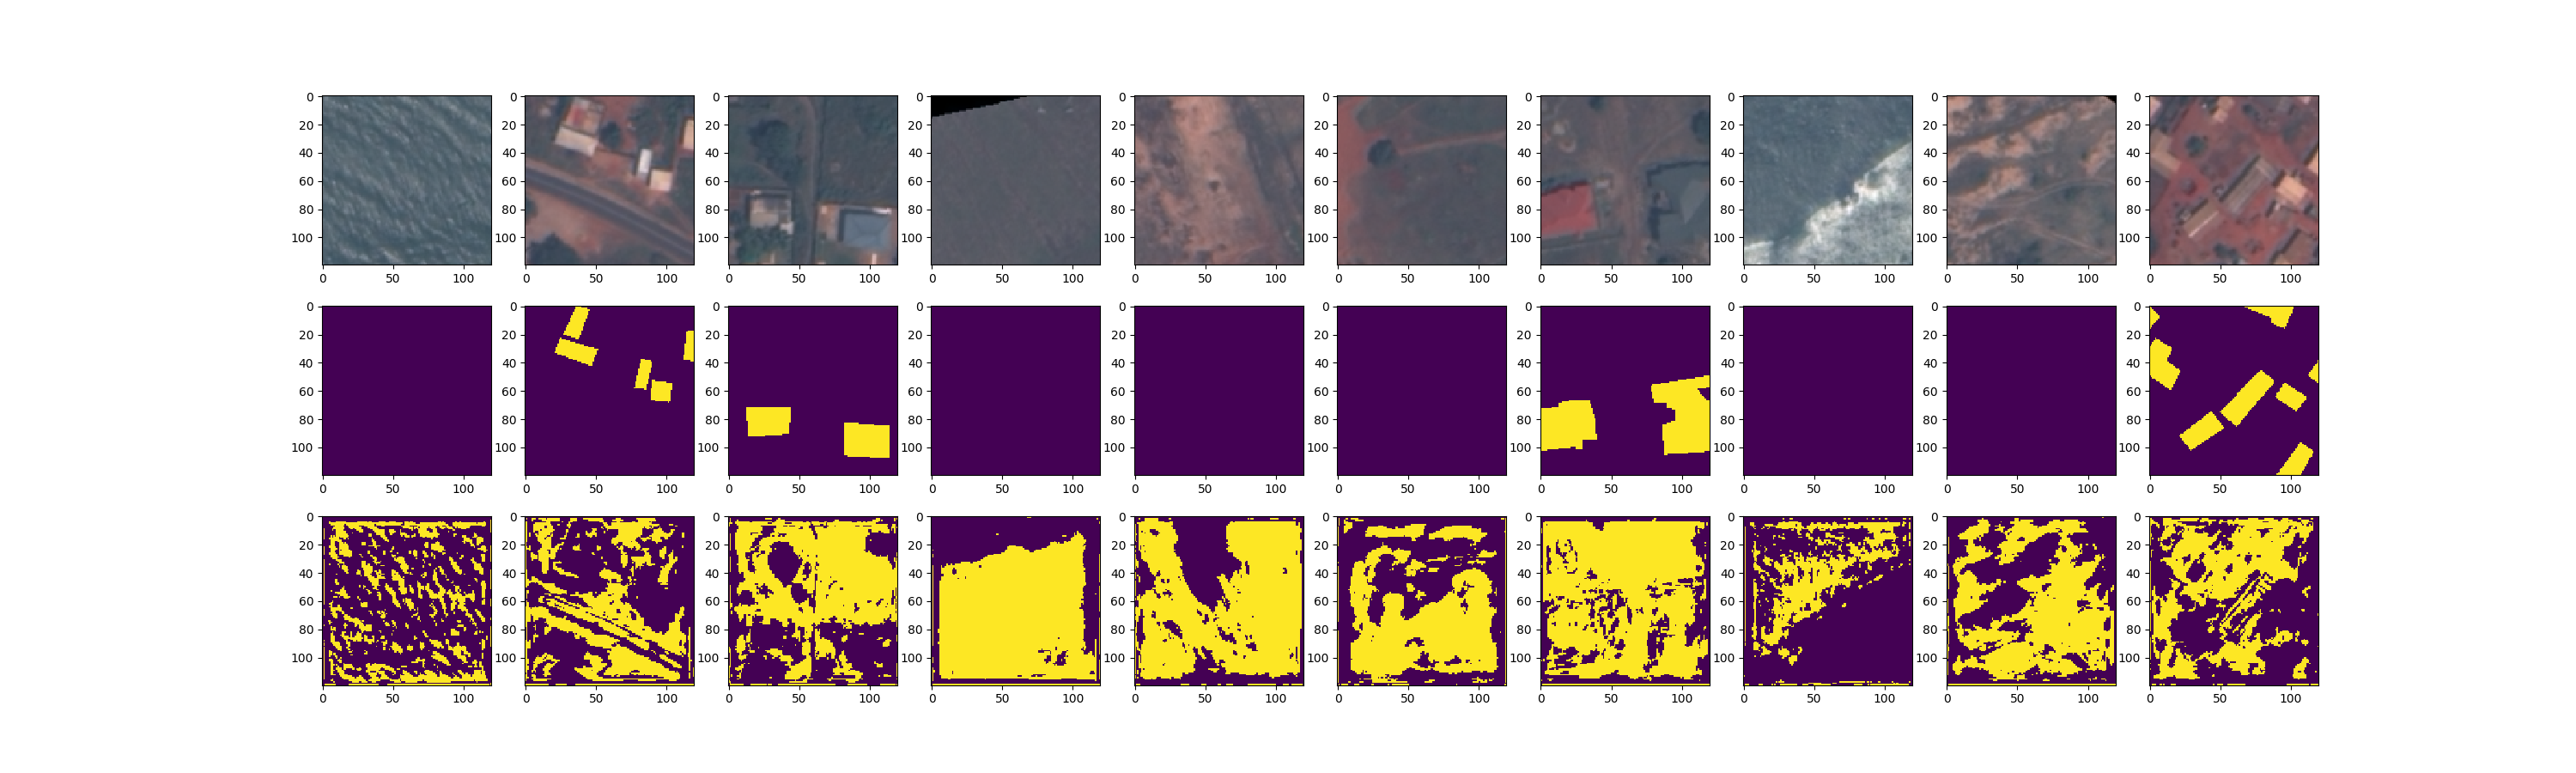

2018-05-06 22:16:59,741 Verification  loss= 0.6547,error= 47.2961%
2018-05-06 22:16:59,800 Start optimization


4958
155


Process Process-4:
Traceback (most recent call last):
  File "/home/s161362/.conda/envs/env_dhi/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/s161362/.conda/envs/env_dhi/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/s161362/.conda/envs/env_dhi/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 55, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/s161362/.conda/envs/env_dhi/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 55, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/nobackup/titans/s161362/2_WORKFOLDER_MASTER_THESIS/dataset_generator_2.py", line 76, in __getitem__
    X,Y=_parse_image(self.paths_input[idx],self.paths_output[idx],self.nb_classes)
  File "/nobackup/titans/s161362/2_WORKFOLDER_MASTER_THESIS/dataset_generator_2.py", line 26, in _parse_i

Traceback (most recent call last):
  File "/home/s161362/.conda/envs/env_dhi/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-1b09cdbed4e5>", line 21, in <module>
    save_path,loss_train,avg_loss_train,loss_verif,iou_verif,iou_acc_verif,f1_iou_verif=trainer.train( root_folder, MODEL_PATH_SAVE, MODEL_PATH_RESTORE,DEFAULT_EPOCHS,DROPOUT, DISPLAY_STEP, DEFAULT_VALID,REC_SAVE, TEST_SAVE,DISTANCE_NET,THRESHOLD,BINS,IOU_STEP,REDUCE_LR_STEPS,DATA_AUG)
  File "<ipython-input-12-d8c66ea96876>", line 111, in train
    for i_batch,sample_batch in enumerate(train_loader):
  File "/home/s161362/.conda/envs/env_dhi/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 275, in __next__
    idx, batch = self._get_batch()
  File "/home/s161362/.conda/envs/env_dhi/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 254, in _get_batch
    return self.data_queue.g

KeyboardInterrupt: 

In [14]:
if __name__ == '__main__':
    
    if UNET_V==0:
        model=UNet(INPUT_CHANNELS,NB_CLASSES,depth =DEFAULT_LAYERS,n_features_zero =DEFAULT_FEATURES_ROOT,dropout=DROPOUT,distance_net=DISTANCE_NET,bins=BINS,batch_norm=BATCH_NORM)
    elif UNET_V==1 or UNET_V==2 or UNET_V==4:
        model=UNet(INPUT_CHANNELS,NB_CLASSES,depth =DEFAULT_LAYERS,n_features_zero =DEFAULT_FEATURES_ROOT,width_kernel=DEFAULT_FILTER_WIDTH,dropout=DROPOUT,distance_net=DISTANCE_NET,bins=BINS,batch_norm=BATCH_NORM)
    elif UNET_V==3:
        model=UNet(INPUT_CHANNELS,NB_CLASSES,num_hidden_features =DEFAULT_HIDDEN_FEATURES,n_resblocks=DEFAULT_N_RESBLOCKS,num_dilated_convs=N_DILATED_CONV,dropout=DROPOUT,gated=DEFAULT_GATED,kernel_size=DEFAULT_FILTER_WIDTH,padding=DEFAULT_PADDING, group_norm=DEFAULT_GROUP_NORM)
    elif UNET_V==5:
        model=DilatedNetwork( INPUT_CHANNELS,NB_CLASSES,num_hidden_features=DEFAULT_HIDDEN_FEATURES_DILATED,n_resblocks=DEFAULT_N_RESBLOCKS, dropout=DROPOUT, padding=DEFAULT_PADDING, kernel_size=DEFAULT_FILTER_WIDTH,batch_norm=BATCH_NORM)
    if WEIGHTS_INIT:
        model.apply(weights_init)

    model.cuda()
    
    cudnn.benchmark = True

    print('### Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))
    
    trainer=Trainer(model,DEFAULT_BATCH_SIZE,DEFAULT_LR,NB_CLASSES)
    save_path,loss_train,avg_loss_train,loss_verif,iou_verif,iou_acc_verif,f1_iou_verif=trainer.train( root_folder, MODEL_PATH_SAVE, MODEL_PATH_RESTORE,DEFAULT_EPOCHS,DROPOUT, DISPLAY_STEP, DEFAULT_VALID,REC_SAVE, TEST_SAVE,DISTANCE_NET,THRESHOLD,BINS,IOU_STEP,REDUCE_LR_STEPS,DATA_AUG)
    print('Last model saved is %s: '%save_path)
    
    fig, axs = plt.subplots(5, sharex=True)

    
    #SAVE loss

    axs[0].set_title('Plot Loss', fontsize=8)
    ite = np.arange(0,len(loss_train),1)
    epo=np.arange(int(len(loss_train)/DEFAULT_EPOCHS)-1,len(loss_train),int(len(loss_train)/DEFAULT_EPOCHS))
    axs[0].plot(ite,loss_train,'b',epo,loss_verif,'g',epo,avg_loss_train,'r')
    axs[0].set_ylabel('Loss')

    
     #SAVE IOU

    axs[1].set_title('Plot IOU', fontsize=8)
    epo=np.arange(int(len(loss_train)/len(iou_verif))-1,len(loss_train),int(len(loss_train)/len(iou_verif)))
    axs[1].plot(epo,iou_verif,'g')
    axs[1].set_ylabel('IOU in %')

    
    #SAVE IOU  acc

    axs[2].set_title('Plot IOU Accuracy', fontsize=8)
    epo=np.arange(int(len(loss_train)/len(iou_acc_verif))-1,len(loss_train),int(len(loss_train)/len(iou_acc_verif)))
    axs[2].plot(epo,iou_acc_verif,'g')
    axs[2].set_ylabel('IOU Accuracy in %')
    


    
     #SAVE f1 IOU

    axs[3].set_title('Plot f1 IOU', fontsize=8)
    epo=np.arange(int(len(loss_train)/len(f1_iou_verif))-1,len(loss_train),int(len(loss_train)/len(f1_iou_verif)))
    axs[3].plot(epo,f1_iou_verif,'g')
    axs[3].set_ylabel('f1 IOU in %')
    
    
     #SAVE loss 2

    axs[4].set_title('Plot Loss', fontsize=8)
    epo=np.arange(int(len(loss_train)/DEFAULT_EPOCHS)-1,len(loss_train),int(len(loss_train)/DEFAULT_EPOCHS))
    axs[4].plot(epo,loss_verif,'g',epo,avg_loss_train,'r')
    axs[4].set_ylabel('Loss')

    
    fig.canvas.draw()
    time.sleep(1)
    plt.close(fig)
